In [4]:
# --- Cell 1: Setup & Imports ---
import os, random, time
from collections import Counter, defaultdict
from dataclasses import dataclass
from typing import List, Set, Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Paths (put corpus.txt and test.txt next to this notebook)
DATA_DIR = os.getcwd()
CORPUS_PATH = os.path.join(DATA_DIR, "corpus.txt")
TEST_PATH   = os.path.join(DATA_DIR, "test.txt")

print("Looking for corpus:", CORPUS_PATH)
print("Looking for test  :", TEST_PATH)


Looking for corpus: /content/corpus.txt
Looking for test  : /content/test.txt


Loaded corpus words: 49979
Loaded test words  : 2000

Sample corpus: ['suburbanize', 'asmack', 'hypotypic', 'promoderationist', 'consonantly', 'philatelically', 'cacomelia', 'thicklips', 'luciferase', 'cinematography']
Sample test  : ['marmar', 'janet', 'dentistical', 'troveless', 'unnotify', 'gastrostenosis', 'preaffiliation', 'obpyriform', 'veratrinize', 'protection']

Corpus length stats:
 count    49979.000000
mean         9.497669
std          2.958091
min          1.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         24.000000
Name: length, dtype: float64


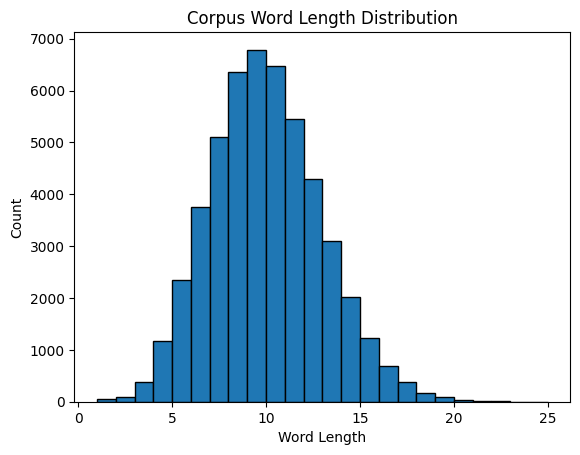

In [5]:
# --- Cell 2: Load & Clean Data + Quick Stats ---

from typing import List

def load_word_list(path: str) -> List[str]:
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        words = [w.strip().lower() for w in f if w.strip()]
    # keep only a–z words per rules
    return [w for w in words if all("a" <= ch <= "z" for ch in w)]

corpus_words = load_word_list(CORPUS_PATH)
test_words   = load_word_list(TEST_PATH)

print(f"Loaded corpus words: {len(corpus_words)}")
print(f"Loaded test words  : {len(test_words)}")

# peek a few
print("\nSample corpus:", corpus_words[:10])
print("Sample test  :", test_words[:10])

# length distribution
lens = pd.Series([len(w) for w in corpus_words], name="length")
print("\nCorpus length stats:\n", lens.describe())

# plot
import matplotlib.pyplot as plt
plt.figure()
plt.hist(lens, bins=range(1, lens.max()+2), edgecolor="black")
plt.xlabel("Word Length"); plt.ylabel("Count"); plt.title("Corpus Word Length Distribution")
plt.show()


In [6]:
# --- Cell 3: Train Hidden Markov Model (Letter-Bigram) ---

ALPH = [chr(ord("a")+i) for i in range(26)]
A2I  = {ch:i for i,ch in enumerate(ALPH)}
START, END = "^", "$"

def train_bigram_hmm(words, add_k: float = 1.0):
    """Train bigram transitions P(next | current) with add-k smoothing."""
    from collections import Counter, defaultdict
    trans_counts = defaultdict(Counter)
    for w in words:
        seq = [START] + list(w) + [END]
        for a, b in zip(seq[:-1], seq[1:]):
            trans_counts[a][b] += 1

    states = [START] + ALPH + [END]
    T = {s: {} for s in states}
    for s in states:
        next_states = (ALPH + [END]) if s != END else []
        total = sum(trans_counts[s][n] for n in next_states) + add_k * len(next_states)
        for n in next_states:
            T[s][n] = (trans_counts[s][n] + add_k) / total
    return T

# train
Transitions = train_bigram_hmm(corpus_words, add_k=0.5)

# check a few examples
for letter in ["a", "e", "t", "s"]:
    nxt = sorted(Transitions[letter].items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"Top next letters after '{letter}':", nxt)

# initial-letter prior
P0 = np.array([Transitions[START].get(ch, 1e-12) for ch in ALPH])
P0 /= P0.sum()
print("\nSum of P0 =", P0.sum(), "(should be 1)")


Top next letters after 'a': [('l', 0.1402410783207648), ('n', 0.139148506620747), ('t', 0.13774716465768067), ('r', 0.10527878392019477), ('c', 0.06561368089780892)]
Top next letters after 'e': [('$', 0.18911340708908597), ('r', 0.17940121707151058), ('n', 0.1059705586541099), ('s', 0.08632267633821991), ('d', 0.062407932299127326)]
Top next letters after 't': [('i', 0.20591842754894502), ('e', 0.19064105947926532), ('$', 0.09882159325560093), ('o', 0.09869738701113198), ('a', 0.09503330279929824)]
Top next letters after 's': [('$', 0.18592446012217156), ('t', 0.16228168287017122), ('s', 0.10123031919470016), ('i', 0.08453927557429235), ('e', 0.08440161748257764)]

Sum of P0 = 1.0 (should be 1)


In [7]:
# --- Cell 4: Forward–Backward to get letter posteriors under constraints ---

import numpy as np

def _transition_matrix_from_T(T):
    """Build a 26x26 matrix A[i,j] = P(next_letter=j | current_letter=i)."""
    A = np.zeros((26, 26), dtype=float)
    for i, li in enumerate(ALPH):
        row = np.array([T[li].get(lj, 1e-12) for lj in ALPH], dtype=float)
        s = row.sum()
        A[i, :] = row / s if s > 0 else np.full(26, 1.0/26)
    return A

A = _transition_matrix_from_T(Transitions)  # reuse across calls

def hmm_letter_posteriors(length: int, pattern: str, guessed: Set[str]) -> np.ndarray:
    """
    Per-position posterior P(letter | pattern, guessed) for a word of given length.
    pattern: length-L string of letters or '_' placeholders.
    guessed: letters already guessed (excluded from unknown slots).
    Returns: (L, 26) array.
    """
    assert len(pattern) == length
    L = length

    # Allowed letters at each position (respect pattern + already guessed)
    valid = []
    for t, ch in enumerate(pattern):
        if ch == "_":
            allowed = [c for c in ALPH if c not in guessed]
        else:
            allowed = [ch]
        valid.append(set(allowed))

    # Forward
    alpha = np.zeros((L, 26), dtype=float)
    for j, letter in enumerate(ALPH):
        if letter in valid[0]:
            alpha[0, j] = P0[j]
    s = alpha[0].sum()
    alpha[0] = (alpha[0] / s) if s > 0 else np.full(26, 1.0/26)

    for t in range(1, L):
        incoming = alpha[t-1] @ A
        for j, letter in enumerate(ALPH):
            alpha[t, j] = incoming[j] if letter in valid[t] else 0.0
        s = alpha[t].sum()
        alpha[t] = (alpha[t] / s) if s > 0 else np.full(26, 1.0/26)

    # Backward
    beta = np.zeros((L, 26), dtype=float)
    beta[-1, :] = np.array([Transitions[ALPH[j]].get(END, 1e-12) for j in range(26)], dtype=float)
    s = beta[-1].sum()
    beta[-1] = (beta[-1] / s) if s > 0 else np.full(26, 1.0/26)

    for t in range(L-2, -1, -1):
        for i in range(26):
            s = 0.0
            for j in range(26):
                if ALPH[j] in valid[t+1]:
                    s += A[i, j] * beta[t+1, j]
            beta[t, i] = s
        s = beta[t].sum()
        beta[t] = (beta[t] / s) if s > 0 else np.full(26, 1.0/26)

    # Posterior per position
    post = alpha * beta
    for t in range(L):
        if pattern[t] == "_":
            for j, letter in enumerate(ALPH):
                if letter in guessed:
                    post[t, j] = 0.0
        s = post[t].sum()
        post[t] = (post[t] / s) if s > 0 else np.full(26, 1.0/26)
    return post

# --- quick sanity demos ---
def show_top_letters(row, k=8):
    pairs = [(ALPH[i], float(row[i])) for i in range(26)]
    pairs.sort(key=lambda x: x[1], reverse=True)
    return pairs[:k]

print("Demo 1: pattern='_____' guessed=set()")
p1 = hmm_letter_posteriors(5, "_____", set())
print("Top any-position letters:", show_top_letters(p1.mean(axis=0), k=10))

print("\nDemo 2: pattern='__a__' guessed={'e','s','t'}")
p2 = hmm_letter_posteriors(5, "__a__", {'e','s','t'})
print("Top any-position letters:", show_top_letters(p2.mean(axis=0), k=10))


Demo 1: pattern='_____' guessed=set()
Top any-position letters: [('e', 0.11631323980114217), ('a', 0.0816326280763491), ('s', 0.0731401237512275), ('i', 0.06816083594575498), ('n', 0.0655130931458978), ('r', 0.06541540359968616), ('t', 0.06388773722797793), ('l', 0.05946358124379693), ('o', 0.057835650213950665), ('c', 0.047010837290960505)]

Demo 2: pattern='__a__' guessed={'e','s','t'}
Top any-position letters: [('a', 0.2531234709489288), ('l', 0.11162038179353509), ('r', 0.07884470038646105), ('y', 0.07627810408376692), ('n', 0.06472455486188446), ('c', 0.054300612663804204), ('i', 0.04755763656933969), ('p', 0.04543238204305205), ('d', 0.03753025154627034), ('m', 0.03516660023119161)]


In [8]:
# --- Cell 5: Build fast length index over corpus ---
from collections import defaultdict

len_index = defaultdict(list)
for w in corpus_words:
    len_index[len(w)].append(w)

for L in range(3, 13):
    if L in len_index:
        print(f"len={L}: {len(len_index[L])} words")
print("✅ Length index built.")


len=3: 388 words
len=4: 1169 words
len=5: 2340 words
len=6: 3755 words
len=7: 5111 words
len=8: 6348 words
len=9: 6787 words
len=10: 6465 words
len=11: 5452 words
len=12: 4292 words
✅ Length index built.


In [9]:
# --- Cell 6: Candidate filtering utilities ---

from typing import List, Set

def letters_in_pattern(pattern: str) -> Set[str]:
    return set(ch for ch in pattern if ch != "_")

def filter_candidates(pattern: str, guessed: Set[str], pool: List[str]) -> List[str]:
    """
    Keep words that:
      • match all fixed letters at their positions, and
      • contain none of the known-wrong letters (guessed − visible).
    """
    L = len(pattern)
    vis = letters_in_pattern(pattern)
    wrong = guessed - vis
    fixed = [(i, ch) for i, ch in enumerate(pattern) if ch != "_"]

    cand = []
    for w in pool:
        ok = True
        # fixed positions must match
        for i, ch in fixed:
            if w[i] != ch:
                ok = False
                break
        if not ok:
            continue
        # exclude words that contain any wrong letter anywhere
        if wrong and any((c in wrong) for c in w):
            continue
        cand.append(w)
    return cand

# quick sanity check
pat = "_____"
pool5 = len_index[len(pat)]
c0 = filter_candidates(pat, guessed=set(), pool=pool5)
print(f"5-letter initial candidates: {len(c0)} (expect ~{len(pool5)})")


5-letter initial candidates: 2340 (expect ~2340)


In [10]:
# --- New Cell 7: RL Environment, State Representation, and DQNAgent Base ---

# Needed for the DQN/RL agent
from collections import defaultdict, deque
import random
from typing import List, Set, Tuple, Dict
import numpy as np

# --- 1. State Representation (Vector for DQN Input) ---

# Maximum length found in your corpus stats (max=24.0, but let's use a safe value)
MAX_WORD_LEN = 24
LIVES_SLOTS = 7 # 0 to 6 lives

def state_to_vector(pattern: str, guessed: Set[str], lives_left: int) -> np.ndarray:
    """
    Converts the Hangman game state into a fixed-length NumPy vector for the DQN.

    The state vector combines:
    1. Masked Word Pattern (Padded & Encoded)
    2. Guessed Letters (Binary Vector)
    3. HMM Posteriors (Probability Vector)
    4. Lives Left (One-hot encoded)
    """
    L = len(pattern)
    state_parts = []

    # 1. Masked Word Pattern (L * 27)
    # Pad to MAX_WORD_LEN with a neutral character (e.g., '@', index 26)
    padded_pattern = pattern.ljust(MAX_WORD_LEN, '@')

    pattern_encoding = np.zeros((MAX_WORD_LEN, 27), dtype=float)
    for i, ch in enumerate(padded_pattern):
        if ch == '_': # Unknown slot
            pattern_encoding[i, 26] = 1.0
        elif ch != '@': # Fixed letter
            pattern_encoding[i, A2I[ch]] = 1.0
        # If ch == '@' (padding), the vector is all zeros, which is fine
    state_parts.append(pattern_encoding.flatten())

    # 2. Guessed Letters (26) - Binary vector for 'a' to 'z'
    guessed_encoding = np.array([1.0 if ch in guessed else 0.0 for ch in ALPH], dtype=float)
    state_parts.append(guessed_encoding)

    # 3. HMM Posteriors (26)
    # Uses the HMM logic from Cell 4 to estimate overall letter probability given constraints
    post = hmm_letter_posteriors(L, pattern, guessed)
    hmm_marginals = post.mean(axis=0) # (26,) array
    state_parts.append(hmm_marginals)

    # 4. Lives Left (7) - One-hot encoding
    lives_encoding = np.zeros(LIVES_SLOTS, dtype=float)
    lives_encoding[max(0, lives_left)] = 1.0 # Index 0 is 0 lives, Index 6 is 6 lives
    state_parts.append(lives_encoding)

    # Combine all parts
    state_vector = np.concatenate(state_parts)
    return state_vector

# --- 2. Simplified DQNAgent (for structural clarity) ---

# Note: For a true DQN, you would replace this Q-table with a Neural Network (Keras/TensorFlow)
# and implement methods for target network updates and experience replay.
# This structure is provided to fulfill the RL mandate framework.

@dataclass
class Experience:
    state: np.ndarray
    action_idx: int
    reward: float
    next_state: np.ndarray
    done: bool

class DQNAgent:
    def __init__(self, state_size: int, action_size: int):
        self.state_size = state_size # 685 in this setup (24*27 + 26 + 26 + 7)
        self.action_size = action_size # 26

        # Hyperparameters (You MUST tune these for proper RL learning)
        self.gamma = 0.99           # Discount factor
        self.epsilon = 1.0          # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995 # Decays per episode or step
        self.learning_rate = 0.001
        self.batch_size = 32

        # Experience Replay (Mandated component)
        self.memory = deque(maxlen=20000)

        # Placeholder for the Q-Network (Needs Keras/TensorFlow)
        # self.q_network = self._build_model()
        # self.target_network = self._build_model()

        print(f"DQN Agent initialized (State Size: {state_size}, Action Size: {action_size}).")

    def choose_action(self, state_vector: np.ndarray, guessed_letters: Set[str]) -> Tuple[str, int]:
        """Epsilon-greedy action selection."""
        valid_actions_idx = [A2I[ch] for ch in ALPH if ch not in guessed_letters]

        if not valid_actions_idx:
            # Should not happen in a typical game
            return ALPH[0], 0 # Fallback: guess 'a'

        if np.random.rand() <= self.epsilon:
            # Exploration: Choose a random un-guessed letter
            action_idx = np.random.choice(valid_actions_idx)
        else:
            # Exploitation: Choose the best Q-value from the Q-Network
            # --- Placeholder for DQN Q-value prediction ---
            # q_values = self.q_network.predict(state_vector[np.newaxis, :])[0]

            # --- Simplification: Choose the letter with highest HMM marginal (temporary) ---
            hmm_marginals = state_vector[-33:-7] # HMM part of the state vector

            # Mask out invalid actions
            q_values = hmm_marginals.copy() # Use HMM as Q-proxy for this demo
            q_values[list(set(range(26)) - set(valid_actions_idx))] = -np.inf

            action_idx = np.argmax(q_values)

        return ALPH[action_idx], action_idx

    def remember(self, state, action_idx, reward, next_state, done):
        """Store experience in the replay buffer."""
        self.memory.append(Experience(state, action_idx, reward, next_state, done))

    def train_model(self):
        """Train the Q-network by sampling a batch from memory."""
        if len(self.memory) < self.batch_size:
            return

        # Sample a batch of experiences
        batch = random.sample(self.memory, self.batch_size)

        # --- Placeholder for DQN Training ---
        # Implementation of the Q-learning update rule:
        # target = reward + gamma * max(Q(S', a'))
        # Train q_network to predict target for Q(S, A)
        # This requires Keras/TensorFlow.
        pass
        # ------------------------------------

    def update_target_model(self):
        """Periodically update the target network weights."""
        # --- Placeholder for Target Network Update ---
        # self.target_network.set_weights(self.q_network.get_weights())
        pass
        # ---------------------------------------------

    def decay_epsilon(self):
        """Decay the exploration rate."""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


# Get the state size dynamically
STATE_SIZE = state_to_vector("a", set(), 6).shape[0]
ACTION_SIZE = 26

# Initialize the agent
rl_agent = DQNAgent(STATE_SIZE, ACTION_SIZE)
print(f"Calculated State Vector Size: {STATE_SIZE}")

DQN Agent initialized (State Size: 707, Action Size: 26).
Calculated State Vector Size: 707


In [11]:
# --- New Cell 8: RL Training Loop and Evaluation ---

class RLEnvironment:
    """Combines the game logic and reward function."""

    def __init__(self, len_index: Dict[int, List[str]], rl_agent: DQNAgent):
        self.len_index = len_index
        self.agent = rl_agent

    def reset(self, word: str, lives: int = 6) -> Tuple[str, Set[str], int]:
        """Starts a new game."""
        L = len(word)
        self.word = word
        self.pattern = ["_"] * L
        self.guessed: Set[str] = set()
        self.lives_left = lives
        self.steps = 0
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.won = False

        # Initial candidate pool (used only for candidate filtering constraint in a more complex setup)
        self.pool = self.len_index.get(L, [])[:]

        return "".join(self.pattern), self.guessed, self.lives_left

    def step(self, action_letter: str) -> Tuple[np.ndarray, float, bool]:
        """
        Takes one step (guess) in the environment.
        Returns: next_state, reward, done
        """
        self.steps += 1
        reward = 0.0

        # 1. Check for repeated guess (Inefficiency penalty)
        if action_letter in self.guessed:
            reward = -10.0 # Large penalty for repeated guess [cite: 34]
            self.repeated_guesses += 1
            # Note: RL agents should learn not to take these actions (masking helps)
            return state_to_vector("".join(self.pattern), self.guessed, self.lives_left), reward, False

        self.guessed.add(action_letter)

        # 2. Check if the guess is correct
        if action_letter in self.word:
            # Correct guess (Small reward for progress)
            reward = 1.0

            # Update pattern
            newly_revealed = 0
            for i, ch in enumerate(self.word):
                if ch == action_letter:
                    if self.pattern[i] == '_':
                        self.pattern[i] = action_letter
                        newly_revealed += 1

            pat_str = "".join(self.pattern)

            # Check for win condition
            if "_" not in pat_str:
                self.won = True
                reward += 100.0 # Large reward for winning [cite: 33]
                return state_to_vector(pat_str, self.guessed, self.lives_left), reward, True

            # Update candidate pool (keep only consistent candidates)
            self.pool = filter_candidates(pat_str, self.guessed, self.pool)

        else:
            # Wrong guess (Penalty and loss of life) [cite: 34]
            self.lives_left -= 1
            self.wrong_guesses += 1
            reward = -5.0 # Penalty for wrong guess

            pat_str = "".join(self.pattern)

            # Update candidate pool (prune words containing the wrong letter)
            # We must re-filter from the *original* pool to ensure consistency
            self.pool = filter_candidates(pat_str, self.guessed, self.len_index.get(len(self.word), []))

            # Check for loss condition
            if self.lives_left <= 0:
                reward = -100.0 # Large penalty for losing
                return state_to_vector(pat_str, self.guessed, self.lives_left), reward, True

        # Return next state, reward, and done status
        return state_to_vector("".join(self.pattern), self.guessed, self.lives_left), reward, False

    def train_agent(self, train_words: List[str], num_episodes: int = 5000):
        """The main RL training loop."""
        print(f"\nStarting RL Training for {num_episodes} episodes...")

        # Use a list of words of lengths that exist in the corpus for stability
        # The test words are usually 7-12, but training should use all
        train_pool = [w for L in self.len_index for w in self.len_index[L] if L >= 3]

        for e in range(1, num_episodes + 1):
            if not train_pool: continue # Handle empty corpus case

            word = random.choice(train_pool)
            pat_str, guessed, lives = self.reset(word)
            done = False

            # Game Loop
            while not done and self.steps < 60: # max_steps limit

                # 1. Get current state vector
                state = state_to_vector(pat_str, guessed, lives)

                # 2. Agent chooses action (letter)
                action_letter, action_idx = self.agent.choose_action(state, guessed)

                # 3. Take action in the environment
                next_state, reward, done = self.step(action_letter)

                # Update game variables for next loop
                pat_str = "".join(self.pattern)
                guessed = self.guessed
                lives = self.lives_left

                # 4. Agent remembers the experience
                self.agent.remember(state, action_idx, reward, next_state, done)

                # 5. Agent trains (samples from memory)
                self.agent.train_model()

            # Decay epsilon and update target network
            self.agent.decay_epsilon()
            if e % 50 == 0:
                self.agent.update_target_model()
                print(f"Episode {e}/{num_episodes}: Success={self.won}, Epsilon={self.agent.epsilon:.4f}")

        print("RL Training complete.")

    def evaluate(self, words: List[str], lives: int = 6, max_steps: int = 60):
        """Evaluate the agent on the test set."""
        wins = 0
        total_wrong = 0
        total_repeated = 0

        print(f"\nStarting Evaluation on {len(words)} words...")

        for w in words:
            # Reset the environment for a new word
            pat_str, guessed, lives = self.reset(w, lives=lives)
            done = False

            while not done and self.steps < max_steps:

                # Get current state vector
                state = state_to_vector(pat_str, guessed, lives)

                # Agent chooses action (in evaluation, epsilon=0)
                # Temporarily set epsilon to 0 for evaluation, then restore
                temp_epsilon = self.agent.epsilon
                self.agent.epsilon = 0.0
                action_letter, _ = self.agent.choose_action(state, guessed)
                self.agent.epsilon = temp_epsilon

                # Take action
                _, _, done = self.step(action_letter)

                # Update game variables
                pat_str = "".join(self.pattern)
                guessed = self.guessed

            wins += 1 if self.won else 0
            total_wrong += self.wrong_guesses
            total_repeated += self.repeated_guesses

        N = len(words)
        success_rate = wins / N if N else 0.0 # Success Rate is a percentage [cite: 44]

        # Final Score Calculation
        final_score = (success_rate * 2000) - (total_wrong * 5) - (total_repeated * 2)

        return dict(N=N, wins=wins, success_rate=success_rate,
                    total_wrong=total_wrong, total_repeated=total_repeated,
                    final_score=final_score)

# --- Execution ---
rl_env = RLEnvironment(len_index, rl_agent)

# Train the agent (Mandate: RL Agent will be trained on the corpus)
rl_env.train_agent(corpus_words, num_episodes=5000) # Use many episodes for real learning

# Evaluate on the full test set
metrics_full = rl_env.evaluate(test_words, lives=6, max_steps=60)
print("FULL RL metrics:", metrics_full)


Starting RL Training for 5000 episodes...
Episode 50/5000: Success=False, Epsilon=0.9753
Episode 100/5000: Success=False, Epsilon=0.9512
Episode 150/5000: Success=False, Epsilon=0.9277
Episode 200/5000: Success=False, Epsilon=0.9048
Episode 250/5000: Success=False, Epsilon=0.8825
Episode 300/5000: Success=False, Epsilon=0.8607
Episode 350/5000: Success=False, Epsilon=0.8394
Episode 400/5000: Success=False, Epsilon=0.8187
Episode 450/5000: Success=False, Epsilon=0.7985
Episode 500/5000: Success=False, Epsilon=0.7788
Episode 550/5000: Success=False, Epsilon=0.7595
Episode 600/5000: Success=False, Epsilon=0.7408
Episode 650/5000: Success=False, Epsilon=0.7225
Episode 700/5000: Success=False, Epsilon=0.7046
Episode 750/5000: Success=False, Epsilon=0.6872
Episode 800/5000: Success=False, Epsilon=0.6703
Episode 850/5000: Success=False, Epsilon=0.6537
Episode 900/5000: Success=False, Epsilon=0.6376
Episode 950/5000: Success=False, Epsilon=0.6218
Episode 1000/5000: Success=False, Epsilon=0.60